In [16]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [18]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [19]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

In [20]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [21]:
price_data = add_features(price_data.copy())

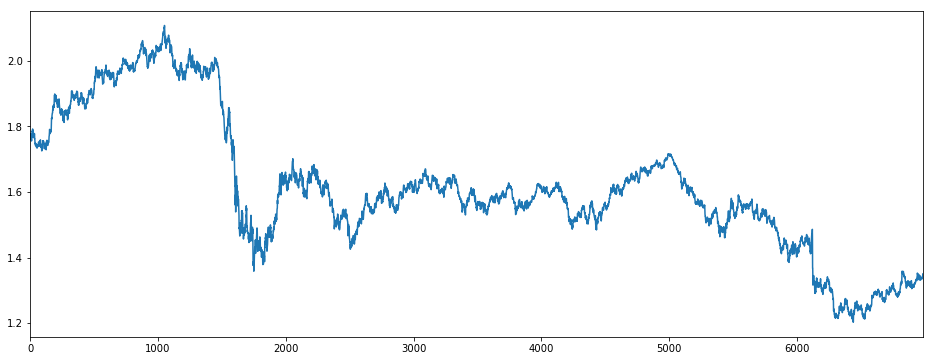

In [22]:
price_data['price'].plot(figsize=(16,6))

In [23]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 4659, test size 2329


In [24]:
episode=1000
batch_size=10

In [25]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-12 12:00:00,1.76080,1.77135,1.75800,1.76825,1.76080,0.494794,0.010280,0.317634
1,1,2006-01-13 00:00:00,1.76665,1.77165,1.75960,1.76080,1.76665,0.500048,0.010723,0.307017
2,2,2006-01-13 12:00:00,1.77740,1.77845,1.76485,1.76665,1.77740,0.606954,0.011444,0.302499
3,3,2006-01-15 12:00:00,1.77780,1.77900,1.77460,1.77460,1.77780,0.614644,0.009680,0.283419
4,4,2006-01-16 00:00:00,1.76935,1.77970,1.76885,1.77780,1.76935,0.497277,0.009973,0.299910


In [26]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [27]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

....................
episode: 20/1000
median profit: 1332 pips, median trade count: 373
....................
episode: 40/1000
median profit: 2713 pips, median trade count: 373
....................
episode: 60/1000
median profit: 3277 pips, median trade count: 382
....................
episode: 80/1000
median profit: 4057 pips, median trade count: 394
....................
episode: 100/1000
median profit: 4693 pips, median trade count: 395
....................
episode: 120/1000
median profit: 4885 pips, median trade count: 395
....................
episode: 140/1000
median profit: 5291 pips, median trade count: 395
....................
episode: 160/1000
median profit: 5401 pips, median trade count: 402
....................
episode: 180/1000
median profit: 5746 pips, median trade count: 396
....................
episode: 200/1000
median profit: 5902 pips, median trade count: 402
....................
episode: 220/1000
median profit: 5971 pips, median trade count: 396
....................
epis

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


....................
episode: 340/1000
median profit: 6420 pips, median trade count: 403
....................
episode: 360/1000
median profit: 6093 pips, median trade count: 407
....................
episode: 380/1000
median profit: 6077 pips, median trade count: 409
....................
episode: 400/1000
median profit: 5939 pips, median trade count: 413
....................
episode: 420/1000
median profit: 5902 pips, median trade count: 413
....................
episode: 440/1000
median profit: 5739 pips, median trade count: 408
....................
episode: 460/1000
median profit: 5739 pips, median trade count: 404
....................
episode: 480/1000
median profit: 5698 pips, median trade count: 402
....................
episode: 500/1000
median profit: 5641 pips, median trade count: 398
....................
episode: 520/1000
median profit: 5627 pips, median trade count: 396
....................
episode: 540/1000
median profit: 5596 pips, median trade count: 395
....................


/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


......
episode: 800/1000
median profit: 5698 pips, median trade count: 379
....................
episode: 820/1000
median profit: 5746 pips, median trade count: 378
....................
episode: 840/1000
median profit: 5793 pips, median trade count: 378
................

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


....
episode: 860/1000
median profit: 5793 pips, median trade count: 378
....................
episode: 880/1000
median profit: 5668 pips, median trade count: 376
....................
episode: 900/1000
median profit: 5739 pips, median trade count: 375
...

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.................
episode: 920/1000
median profit: 5691 pips, median trade count: 374
....................
episode: 940/1000
median profit: 5668 pips, median trade count: 373
....................
episode: 960/1000
median profit: 5655 pips, median trade count: 372
....................
episode: 980/1000
median profit: 5655 pips, median trade count: 371
....................
episode: 1000/1000
median profit: 5668 pips, median trade count: 370


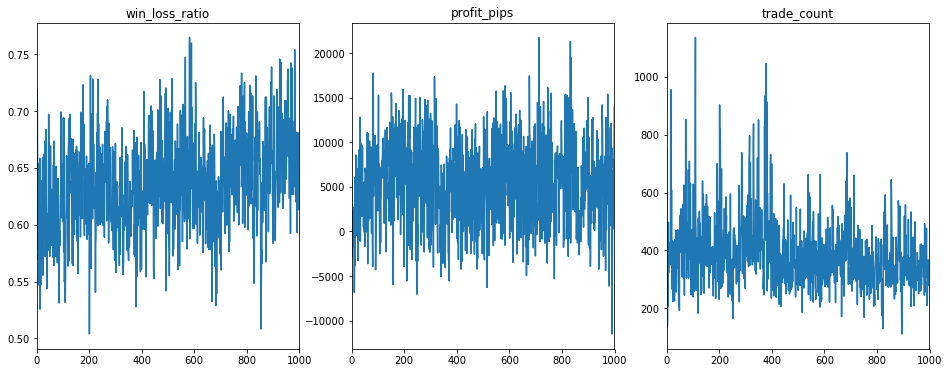

In [28]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [29]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['12h-GBP_USD.pkl']

## Test

In [30]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [31]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [32]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [33]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 336.59999999994693 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134db8ed0>]],
      dtype=object)

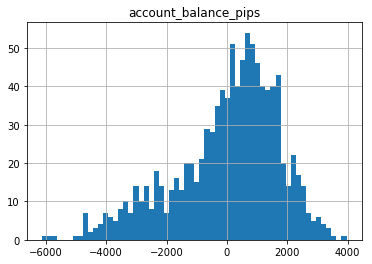

In [34]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [35]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [36]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [37]:
env._stats()

{'trade_count': 119,
 'win_loss_ratio': 0.6302521008403361,
 'account_balance': 0.01305499999999249,
 'unrealised_pl': -0.01014500000000007}

In [38]:
position_data = env.price_data.copy()

In [39]:
position_data['position'] = position_data['position'] - 1

In [40]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

121 positions to plot...


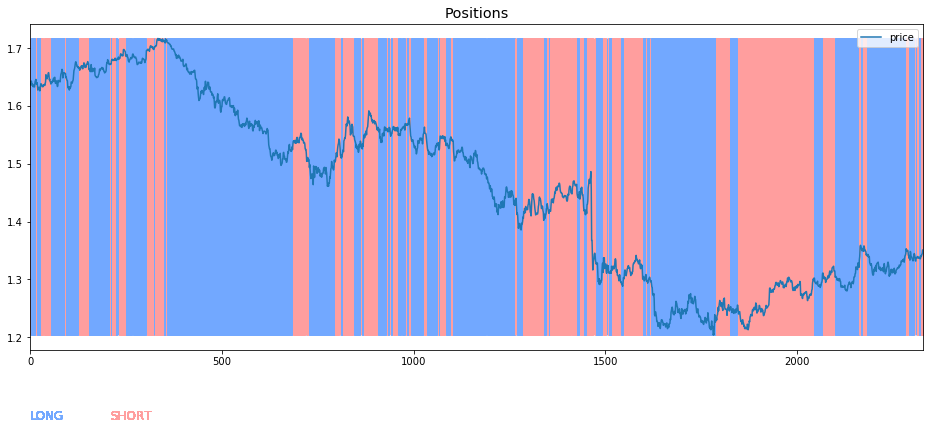

In [41]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [42]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 61.98%
Ratio of long to short positions: 1.0
Median profit: 0.0
Total profit: 0.011909999999998089
Median position length: 7.0
Number of trades: 121


In [43]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-12-01 12:00:00,1.63774,2013-12-02 00:00:00,1.63810,1,NaN,NaN,False,NaN
1,2013-12-02 00:00:00,1.63810,2013-12-10 00:00:00,1.64396,13,1.0,0.00586,True,0.00586
2,2013-12-10 00:00:00,1.64396,2013-12-12 12:00:00,1.63386,5,-1.0,0.01010,True,0.01596
3,2013-12-12 12:00:00,1.63386,2013-12-19 00:00:00,1.63716,10,1.0,0.00330,True,0.01926
4,2013-12-19 00:00:00,1.63716,2013-12-23 00:00:00,1.63576,5,-1.0,0.00140,True,0.02066
...,...,...,...,...,...,...,...,...,...
116,2017-12-14 12:00:00,1.34332,2017-12-17 12:00:00,1.33165,3,-1.0,0.01167,True,0.01685
117,2017-12-17 12:00:00,1.33165,2017-12-19 00:00:00,1.33689,3,1.0,0.00524,True,0.02209
118,2017-12-19 00:00:00,1.33689,2017-12-22 00:00:00,1.33869,6,-1.0,-0.00180,False,0.02029
119,2017-12-22 00:00:00,1.33869,2017-12-27 12:00:00,1.34038,6,1.0,0.00169,True,0.02198


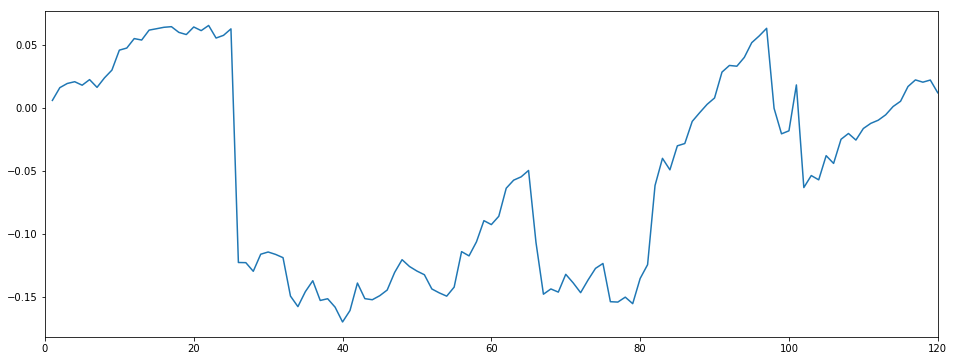

In [44]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.2567200000000006


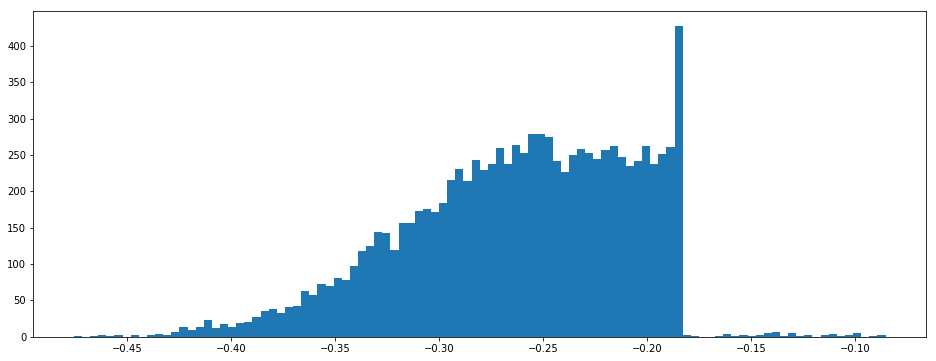

In [45]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);